# Differential abundance - Extended

The notebook on 'Differential abundance - Basics' only explained two different methods for doing DA analysis. There are however many different methods, and choosing the best is not a simple task. Benchmark studies have shown that different methods have different strengths, and the choice of methods therefore in part relies on the specific dataset in question. The [DAtest package](https://github.com/russel88/datest) tries to solve this problem by testing a lot if different methods on your own dataset and provide some statistics on their performance. The details can be found in the [wiki](https://github.com/russel88/datest/wiki), but the basic idea is that the predictor if interest (e.g. treatment/control) is shuffled. Then some random features (ASVs) we multiply the abundance of with some number (e.g. 5), AKA spiked, but only for the shuffled treatment samples. We then apply the diferent DA methods and check if they can find the ASVs which were increased in abundance for the shuffled predictor. The predictor is shuffled to remove any true effect present in the dataset. This procedure is repeated several times, by default 20, to evaluate the consistency of the performance.

Another feature of DAtest is that it is easy to run several different methods and compare their output. One could for example run 3 methods known to perform well, and then use their combined results for a less biased DA analysis.

In [1]:
# Load phyloseq object and phyloseq package
library(phyloseq)
load("../data/physeq.RData")

In [2]:
library(DAtest)

DAtest version 2.7.15


# Contents
* [preDA](#pre)
* [testDA](#test)
* [allDA](#all)

## preDA<a class="anchor" id="pre"></a>

As explained in the Basics notebook, we always want to prepare our data first, especially by pruning low abundant taxa

#### In R:

In [3]:
# Agglomorate to Genus level
phy_genus <- tax_glom(phy, "Genus")

# Only keep genera present in at least 10 samples
phy_genus_pre <- preDA(phy_genus, min.samples = 10)

213 features grouped as 'Others' in the output


## testDA<a class="anchor" id="test"></a>
testDA runs all the different methods and compares them by their empirical power (ability to detect spiked features), their False Discovery Rate (FDR, fraction of significant features which are false positives), and their AUC (area under the ROC curve, ability to rank the features from most to least associated to the predictor). This is all combined into a score, which ranks the different methods. The method with the highest score should perform best.

It is important to note that DAtest assumes that most features are NOT associated with the predictor. Therefore, if for example your control and treatment samples are very different (clearly separated in a PCoA ordination), then only the False Positive Rate (FPR) can be used to weed out bad methods, but the other measures are not trustworthy.


#### In R:

In [ ]:
res <- testDA(phy_genus_pre, predictor = "Delivery")

In [5]:
summary(res)

                     Method  AUC  FPR  FDR Power Score Score.5% Score.95%  
        MgSeq Feature (msf) 0.73 0.04 0.00  0.07  0.02    -0.12      0.04 *
          LIMMA - CLR (lic) 0.62 0.04 0.00  0.00  0.00     0.00      0.01 *
               Wilcox (wil) 0.54 0.04 0.00  0.00  0.00     0.00      0.01 *
               t-test (ttt) 0.53 0.04 0.00  0.00  0.00     0.00      0.00 *
         t-test - ALR (tta) 0.62 0.03 0.00  0.00  0.00    -1.08      0.00 *
          LIMMA - ALR (lia) 0.64 0.03 0.00  0.00  0.00    -1.01      0.01 *
            Log LIMMA (lli) 0.61 0.04 0.00  0.00  0.00    -1.00      0.02 *
    Quasi-Poisson GLM (qpo) 0.60 0.08 0.00  0.00  0.00    -1.00      0.01 *
           Log t-test (ltt) 0.59 0.07 0.00  0.00  0.00    -1.00      0.01 *
         t-test - CLR (ttc) 0.57 0.05 0.00  0.00  0.00    -1.00      0.01 *
           LIMMA voom (vli) 0.57 0.07 0.00  0.00  0.00    -1.00      0.00 *
         Log t-test2 (ltt2) 0.59 0.08 0.00  0.00  0.00    -1.00      0.00 *
          Pe

MetagenomeSeq Feature (msf) method appears to be the best. However, the bootstrapped confidence interval (Score.5% and Score.95%) show that many methods are indistugishiable from msf (\*). 

Let's run the msf method:

In [6]:
res_msf <- DA.msf(phy_genus_pre, predictor = "Delivery")

Default value being used.
Warning message:
"Partial NA coefficients for 1 probe(s)"

In [9]:
res_msf[res_msf$pval.adj <= 0.05, ]

Feature,+samples in group 0,+samples in group 1,counts in group 0,counts in group 1,logFC,se,pval,adjPvalues,pval.adj,ordering,Method,Kingdom,Phylum,Class,Order,Family,Genus,asv_hash


Nothing significant...

## allDA<a class="anchor" id="all"></a>
allDA runs the different methods on the actual dataset. This way you can easily compare the different methods. Let's try it out.

In [10]:
res_all <- allDA(phy_genus_pre, predictor = "Delivery")

Running on 7 cores
predictor is assumed to be a categorical variable with 2 levels: Normal, Sectio


Running 25 methods...
  |======================================================================| 100%

ds2x, erq2, ere2 were excluded due to failure


An easy comparison is by creating Euler (Venn) diagrams of features which are found significant. 

As our best method did not find any significant features, let's try to create a diagram with 3 methods which all seem to find a lot of false positives.

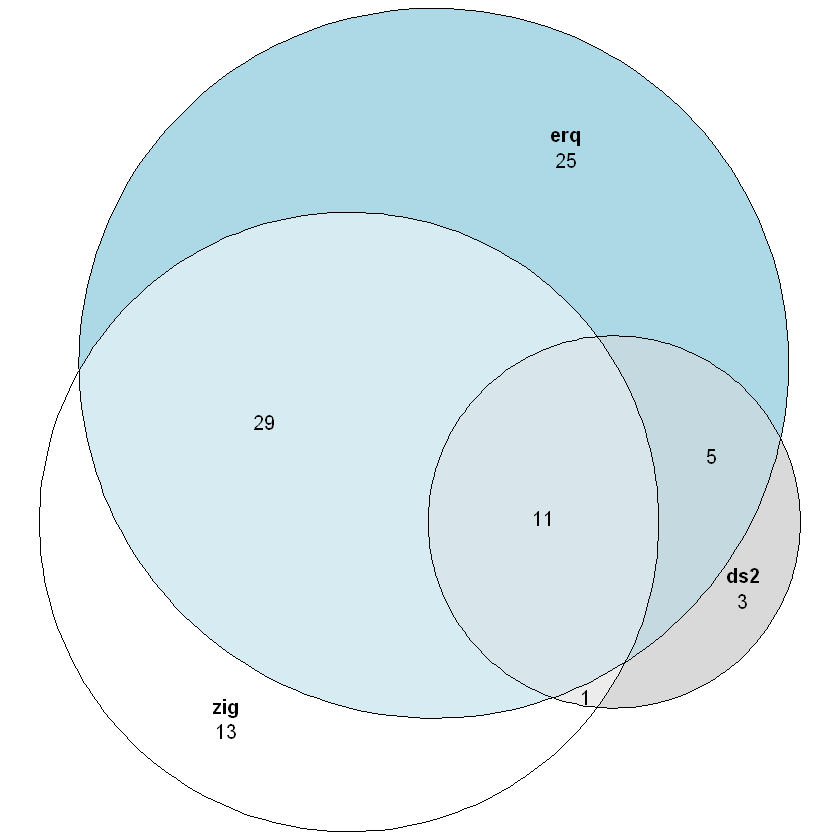

In [16]:
vennDA(res_all, tests = c("zig", "ds2", "erq"))

The 11 features found significant by all 3 methods might be truly differentially abundant, but let's ensure that the sign of the log fold change is similar:

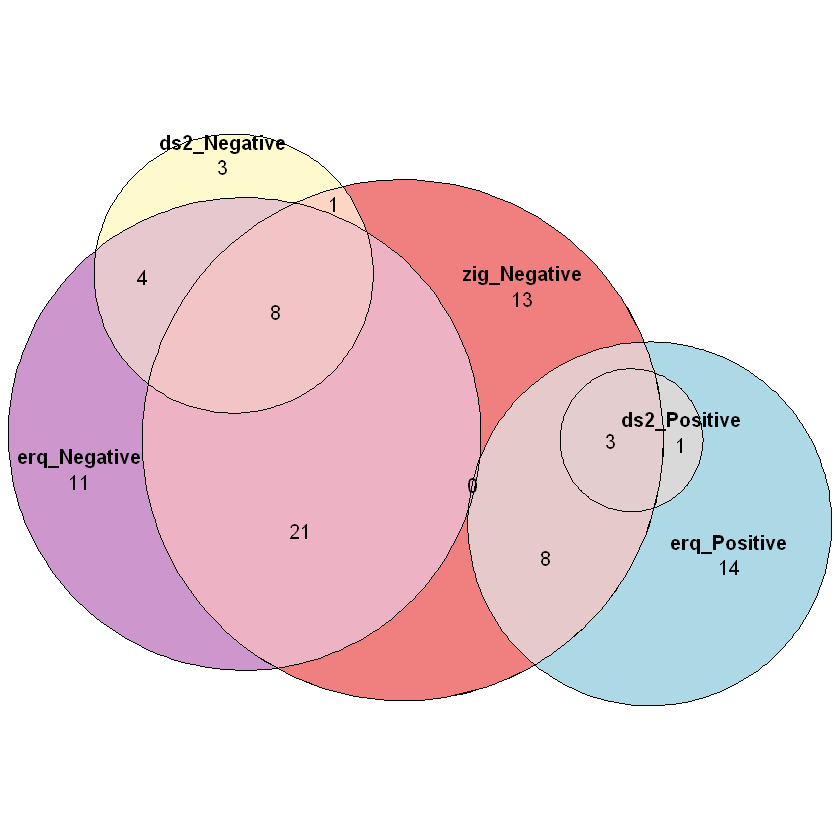

In [17]:
vennDA(res_all, tests = c("zig", "ds2", "erq"), split = TRUE)

Argh! Doesn't look too good. 8 features are significant with a negative log fold change, but 3 features have a positive log fold change with ds2 and erq but negative with zig. If the signs are not matching, then we would not know in which group the features have the highest abundance.